In [1]:
%matplotlib widget

In [2]:
import sys
sys.path.append('..')

import numpy as np
from tqdm.auto import tqdm

from seismicpro.src import Survey
from seismicpro.src.statics_correction import StaticCorrection

In [3]:
path = '/data/H5_LB/BL10_flat2.sgy'
path_fp = '/data/H5_LB/BL10_fbp_2branc'
survey = Survey(path, header_index=['INLINE_3D', 'CROSSLINE_3D'], name='raw', header_cols='all')
survey = survey.load_first_breaks(path_fp)

/notebooks/anton/geolog/pull_requests/statics/SeismicPro/examples/../seismicpro/src/survey/survey.py:124: RuntimeWarning: An automatically reconstructed TRACE_SEQUENCE_FILE header will be used instead of the one, contained in BL10_flat2
  warnings.warn(warn_msg, RuntimeWarning)


In [4]:
survey.apply(lambda FirstBreak, SourceUpholeTime: np.clip(FirstBreak - SourceUpholeTime, 1, None),
             cols=['FirstBreak', 'SourceUpholeTime'],
             res_cols='FirstBreakShifted',
             inplace=True, 
             unpack_args=True)

In [5]:
sp_params = {"size": (11, 11),
             "step": (20, 40),
             "modulo": (1, 0)}

In [6]:
def _calculate_crossover(v1, t1, v2, t2):
    return ((t2 - t1)*v1*v2) / (v2 - v1)
    
def construct_wv(survey, sp_params, first_breaks_col='FirstBreakShifted', direct_wave_params=None, 
                 min_vel_diff=0.1):
    # Calculate weathering velocity in some points and fit NearestNeighbors based on them
    sp_survey = survey.generate_supergathers(**sp_params)
    coords_to_params = {}
    for ix in tqdm(sp_survey.headers.index.unique()):
        g = sp_survey.get_gather(ix)
        wv = g.calculate_weathering_velocity(n_layers=2, init={"t0": 0}, first_breaks_col=first_breaks_col)
        coords = survey.headers.loc[ix][['CDP_X', 'CDP_Y']].values[0]

        if direct_wave_params is not None:
            v1, t1 = direct_wave_params
            v2 = wv.params['v1']
            t2 = wv.params['t0']
            xc = _calculate_crossover(v1, t1, v2, t2)
        else:
            v1, v2, xc = [getattr(wv, param) for param in ['v1', 'v2', 'x1']]

        if (v2 - v1) < min_vel_diff:
            continue

        coords_to_params.update({tuple(coords): [v1, v2, xc]})
    if len(coords_to_params) == 0:
        raise ValueError('Weathering velocities dict is empty.')
    return coords_to_params 

In [7]:
coords_to_params = construct_wv(survey, sp_params, direct_wave_params=(0.8, 0))

  0%|          | 0/298 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [8]:
sc = StaticCorrection(survey, coords_to_params, first_breaks_col='FirstBreakShifted')

In [9]:
sc.calculate_thicknesses(debug=True)

Reason 2, Iter 157, MAE 6879.789258678645


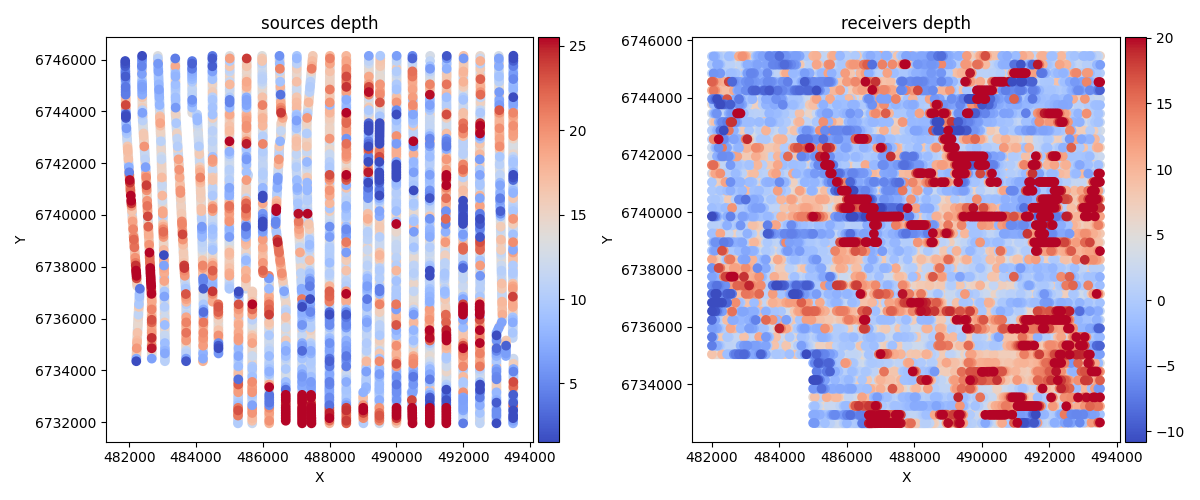

In [11]:
sc.plot_depths()

In [23]:
sc.plot_applied_static_map('static_error', datum=30, sp_params=sp_params)